<a href="https://colab.research.google.com/github/gprashant17085/OCR-implemention-using-EAST-model/blob/master/ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

!pip install --upgrade imutils
!pip install opencv-python
!pip install requests

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [0]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import json
import cv2
import requests
from skimage import io
from google.colab.patches import cv2_imshow

In [0]:

r = requests.get('https://rhumn4n489.execute-api.us-east-2.amazonaws.com/dev/menu/chipotle')
data = r.json() 

# myobj = {"menuID": "somevalue",
#          "path": "somepath"}
# myobj = {"menuID": "shabu_shabu",
#          "path": "https://heali-interview-screening.s3.amazonaws.com/fad7d132.jpg"}
# x = requests.post("https://rhumn4n489.execute-api.us-east-2.amazonaws.com/dev/menu", json = myobj)

# x = requests.post("https://rhumn4n489.execute-api.us-east-2.amazonaws.com/dev/menu", json = myobj)

In [0]:
# urls = [
# 	"https://heali-interview-screening.s3.amazonaws.com/35ad4af5.jpg",
# 	"https://heali-interview-screening.s3.amazonaws.com/f871bf12.jpg",
# 	"https://heali-interview-screening.s3.amazonaws.com/31318eea.jpg",
# ]

# for url in urls:
# 	# download the image using scikit-image
# 	print("downloading %s" + (url))
idd = data["menuID"]
image = data['path']
print(image)
print(idd)
image = io.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()
(H, W) = image.shape[:2]
print('Image Height       : ', H)
print('Image Width        : ', W)
# cv2_imshow(image)
def myround(x, base=32):
    return base * round(x/base)
print('Image Height       : ', myround(H))
print('Image Width        : ', myround(W))	
# cv2.waitKey(0)


https://heali-interview-screening.s3.amazonaws.com/35ad4af5.jpg
chipotle
Image Height       :  1541
Image Width        :  830
Image Height       :  1536
Image Width        :  832


In [0]:
# image = cv2.imread("/content/drive/My Drive/Colab Notebooks/opencv-text-detection/images/car_wash.png")
# orig = image.copy()
# (H, W) = image.shape[:2]


In [0]:
# set the new width and height and then determine the ratio in change
# for both the width and height

(newW, newH) = (myround(W), myround(H))

rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]


In [0]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("/content/drive/My Drive/Colab Notebooks/opencv-text-detection/frozen_east_text_detection.pb")

[INFO] loading EAST text detector...


In [0]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
boxcord = []

[INFO] text detection took 5.581351 seconds


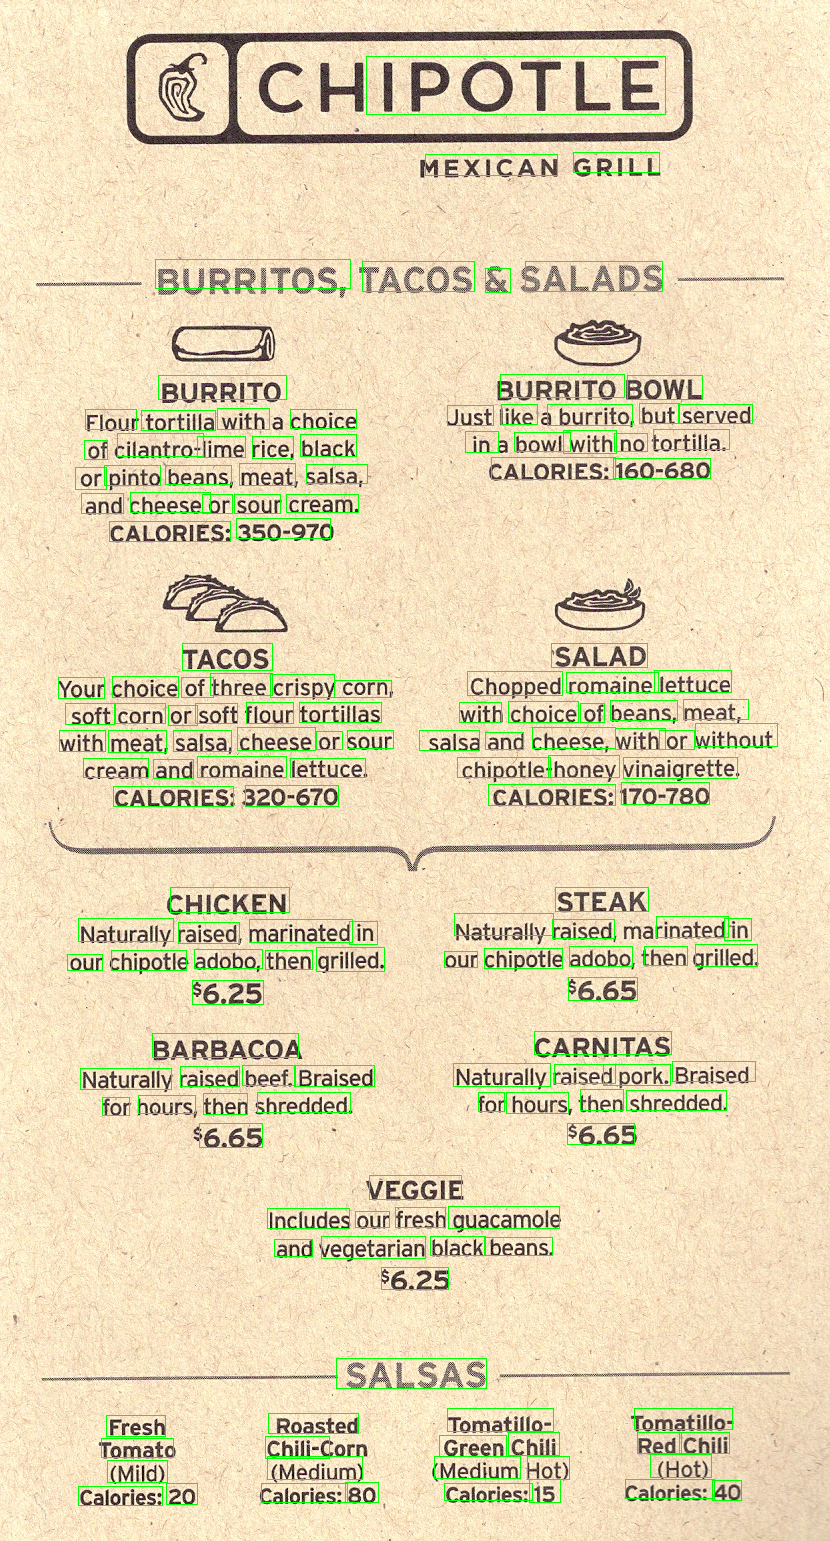

-1

In [0]:

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

	# loop over the number of columns
		for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.5:
				continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
	 		
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
	  
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes

boxes = non_max_suppression(np.array(rects), probs=confidences)


# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		width = int(endX-startX)
		height = int(endY-startY)
	# draw the bounding box on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 1)
		boxcord.append((startX, startY, width, height))
# show the output image

outbox = json.dumps(boxcord)

myobj = {"menuID": idd,
         "jsons": outbox}
x = requests.post("https://rhumn4n489.execute-api.us-east-2.amazonaws.com/dev/jsons", json = myobj)
cv2_imshow(orig)
cv2.waitKey(0)
